<a href="https://colab.research.google.com/github/naips/Auto-AI/blob/main/Fine_Tuning_BERT_for_News_Classification_small_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Transformers Library

In [1]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [4]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


# Load Dataset

In [5]:
df = pd.read_csv("test.csv")
df.head()

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [6]:
df.shape

(7600, 3)

In [7]:
df['text'] = df['Title'] + ' ' + df['Description']

In [8]:
df['label'] = df['Class Index']

In [9]:

df['label'] = df['label'].map({1:0, 2:1, 3:2, 4:3})

# Split train dataset into train, validation and test sets

In [10]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [11]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model", "bert model embeddings are context based"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [13]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102, 0], [101, 14324, 2944, 7861, 8270, 4667, 2015, 2024, 6123, 2241, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [14]:
sent_id['input_ids']

[[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0, 0],
 [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102, 0],
 [101, 14324, 2944, 7861, 8270, 4667, 2015, 2024, 6123, 2241, 102]]

# Tokenization

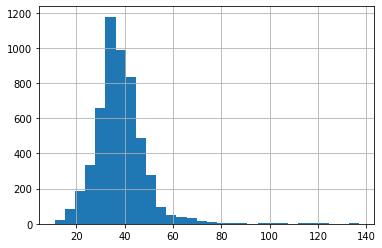

In [15]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [16]:
max_seq_len = 50

In [17]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Convert Integer Sequences to Tensors

In [18]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [19]:
train_mask

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])

# Create DataLoaders

In [20]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 64

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [21]:
x = [w for w in train_dataloader]

In [22]:
x[0][0][0]

tensor([  101,  2047,  4501,  5239,  2089,  2022, 10741,  1999,  2651, 26905,
         1010,  1024,  1037,  2047,  5239,  1999,  4501,  2003,  3497,  2000,
         2022, 10741,  1999,  2006,  6928,  1010,  2048,  2420,  2044,  5446,
         2704, 21146, 15750,  2102, 21196,  2001,  2081,  1996,  2406,  1001,
         4464,  1025,  1055, 13928,  3539,  2704,  1012,   102,     0,     0])

# Freeze BERT Parameters

In [23]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [24]:
# ultimate layer
[w.shape for w in bert.parameters()][-1]

torch.Size([768])

# Define Model Architecture

In [25]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,4)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [26]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [27]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# Find Class Weights

In [28]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1. 1. 1. 1.]


In [29]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [30]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [31]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
 #     elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [32]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of     84.

Evaluating...

Training Loss: 1.121
Validation Loss: 0.927

 Epoch 2 / 10
  Batch    50  of     84.

Evaluating...

Training Loss: 0.775
Validation Loss: 0.677

 Epoch 3 / 10
  Batch    50  of     84.

Evaluating...

Training Loss: 0.671
Validation Loss: 0.587

 Epoch 4 / 10
  Batch    50  of     84.

Evaluating...

Training Loss: 0.612
Validation Loss: 0.630

 Epoch 5 / 10
  Batch    50  of     84.

Evaluating...

Training Loss: 0.590
Validation Loss: 0.527

 Epoch 6 / 10
  Batch    50  of     84.

Evaluating...

Training Loss: 0.547
Validation Loss: 0.544

 Epoch 7 / 10
  Batch    50  of     84.

Evaluating...

Training Loss: 0.537
Validation Loss: 0.476

 Epoch 8 / 10
  Batch    50  of     84.

Evaluating...

Training Loss: 0.556
Validation Loss: 0.535

 Epoch 9 / 10
  Batch    50  of     84.

Evaluating...

Training Loss: 0.521
Validation Loss: 0.505

 Epoch 10 / 10
  Batch    50  of     84.

Evaluating...

Training Loss: 0.511
Validation L

# Load Saved Model

In [33]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [34]:
torch.cuda.empty_cache()


In [35]:
import gc
gc.collect()

132

In [36]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [37]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       285
           1       0.90      0.95      0.93       285
           2       0.81      0.75      0.78       285
           3       0.82      0.83      0.82       285

    accuracy                           0.85      1140
   macro avg       0.85      0.85      0.85      1140
weighted avg       0.85      0.85      0.85      1140



In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,710,14
1,9,103


In [1]:
!pip install allennlp

     |████████████████████████████████| 686kB 24.2MB/s 
     |████████████████████████████████| 1.8MB 43.9MB/s 
     |████████████████████████████████| 12.1MB 259kB/s 
     |████████████████████████████████| 1.2MB 18.2MB/s 
     |████████████████████████████████| 122kB 51.8MB/s 
     |████████████████████████████████| 2.3MB 48.4MB/s 
     |████████████████████████████████| 112kB 59.0MB/s 
     |████████████████████████████████| 133kB 56.7MB/s 
     |████████████████████████████████| 266kB 54.5MB/s 
     |████████████████████████████████| 102kB 14.2MB/s 
     |████████████████████████████████| 174kB 58.0MB/s 
     |████████████████████████████████| 133kB 55.6MB/s 
     |████████████████████████████████| 22.3MB 113kB/s 
     |████████████████████████████████| 174kB 53.7MB/s 
     |████████████████████████████████| 901kB 52.0MB/s 
     |████████████████████████████████| 3.3MB 43.8MB/s 
     |████████████████████████████████| 81kB 10.5MB/s 
     |████████████████████████████████| 81kB 11.9